# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [2]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: C:\Users\leoli\Lab1ScalableMLDL
HopsworksSettings initialized!


In [3]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [4]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 18, 12, 56, 26, 947009)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [5]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-18 12:56:27,025 INFO: Initializing external client
2025-11-18 12:56:27,025 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 12:56:27,736 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-18 12:56:29,002 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286319


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [6]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-18 12:56:31,425 INFO: There is no parent information


Downloading: 0.000%|          | 0/552070 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/133221 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/20148 elapsed<00:00 remaining<?

In [7]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='3.1029833E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [ ]:
weather_fg = fs.get_feature_group(
    name='weather_glasgow',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.79s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-19 00:00:00+00:00,3.20,0.0,9.686609,318.012878,glasgow
1,2025-11-23 00:00:00+00:00,6.85,0.1,9.178235,228.179916,glasgow
2,2025-11-22 00:00:00+00:00,6.00,0.4,26.319420,130.006195,glasgow
3,2025-11-20 00:00:00+00:00,3.95,0.0,10.495713,329.036316,glasgow
4,2025-11-21 00:00:00+00:00,5.35,0.0,19.242327,197.418060,glasgow


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [9]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2025-11-19 00:00:00+00:00,3.20,0.0,9.686609,318.012878,glasgow,20.736082
1,2025-11-23 00:00:00+00:00,6.85,0.1,9.178235,228.179916,glasgow,18.978769
2,2025-11-22 00:00:00+00:00,6.00,0.4,26.319420,130.006195,glasgow,34.369556
3,2025-11-20 00:00:00+00:00,3.95,0.0,10.495713,329.036316,glasgow,27.282513
4,2025-11-21 00:00:00+00:00,5.35,0.0,19.242327,197.418060,glasgow,33.880615


In [10]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         5 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          5 non-null      float32                
 2   precipitation_sum            5 non-null      float32                
 3   wind_speed_10m_max           5 non-null      float32                
 4   wind_direction_10m_dominant  5 non-null      float32                
 5   city                         5 non-null      object                 
 6   predicted_pm25               5 non-null      float32                
dtypes: datetime64[us, Etc/UTC](1), float32(5), object(1)
memory usage: 308.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [11]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-19 00:00:00+00:00,3.20,0.0,9.686609,318.012878,glasgow,20.736082,High-Street,unitedkingdom,1
3,2025-11-20 00:00:00+00:00,3.95,0.0,10.495713,329.036316,glasgow,27.282513,High-Street,unitedkingdom,4
4,2025-11-21 00:00:00+00:00,5.35,0.0,19.242327,197.418060,glasgow,33.880615,High-Street,unitedkingdom,5
2,2025-11-22 00:00:00+00:00,6.00,0.4,26.319420,130.006195,glasgow,34.369556,High-Street,unitedkingdom,3
1,2025-11-23 00:00:00+00:00,6.85,0.1,9.178235,228.179916,glasgow,18.978769,High-Street,unitedkingdom,2


In [12]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 0 to 1
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         5 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          5 non-null      float32                
 2   precipitation_sum            5 non-null      float32                
 3   wind_speed_10m_max           5 non-null      float32                
 4   wind_direction_10m_dominant  5 non-null      float32                
 5   city                         5 non-null      object                 
 6   predicted_pm25               5 non-null      float32                
 7   street                       5 non-null      object                 
 8   country                      5 non-null      object                 
 9   days_before_forecast_day     5 non-null      int64                  
dtypes: datetime

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2025-11-18 12:56:40,012 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



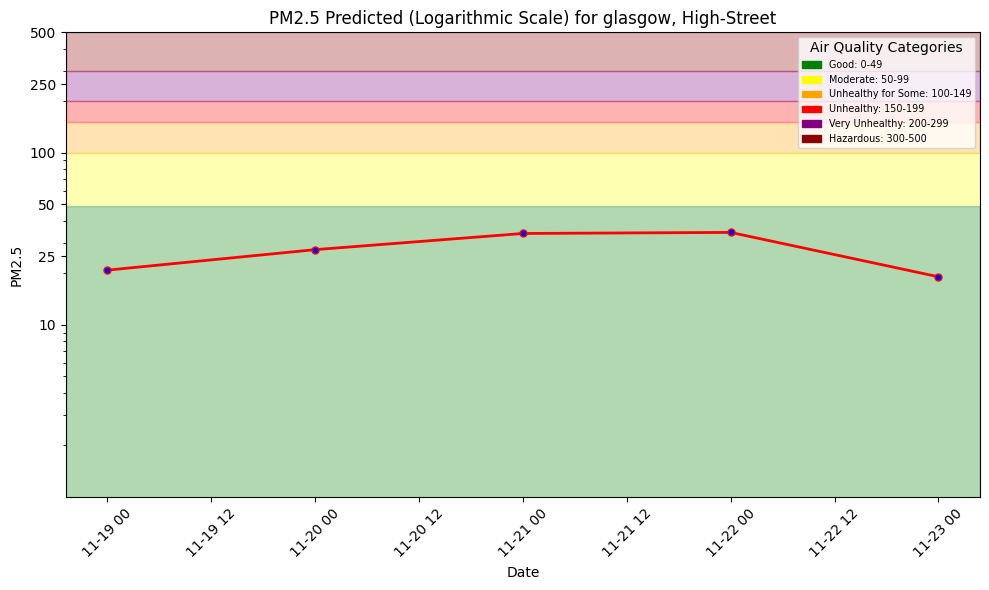

In [13]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [14]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [15]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 5/5 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286319/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-18 12:56:59,909 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 12:57:03,080 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 12:58:44,963 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 12:58:45,120 INFO: Waiting for log aggregation to finish.
2025-11-18 12:59:03,750 INFO: Execution finished successfully.


(Job('aq_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [16]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.14s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-19 00:00:00+00:00,3.20,0.0,9.686609,318.012878,glasgow,20.736082,High-Street,unitedkingdom,1
1,2025-11-17 00:00:00+00:00,3.85,0.0,2.160000,270.000000,glasgow,32.463196,High-Street,unitedkingdom,1


In [17]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.12s) 


,date,pm25,country,city,street,url
0,2019-03-12 00:00:00+00:00,21.0,unitedkingdom,glasgow,High-Street,https://api.waqi.info/feed/@8050
1,2018-12-21 00:00:00+00:00,28.0,unitedkingdom,glasgow,High-Street,https://api.waqi.info/feed/@8050
2,2024-09-26 00:00:00+00:00,10.0,unitedkingdom,glasgow,High-Street,https://api.waqi.info/feed/@8050
3,2017-12-12 00:00:00+00:00,50.0,unitedkingdom,glasgow,High-Street,https://api.waqi.info/feed/@8050
4,2023-06-21 00:00:00+00:00,24.0,unitedkingdom,glasgow,High-Street,https://api.waqi.info/feed/@8050
...,...,...,...,...,...,...
3809,2025-10-24 00:00:00+00:00,17.0,unitedkingdom,glasgow,High-Street,https://api.waqi.info/feed/@8050
3810,2017-11-30 00:00:00+00:00,18.0,unitedkingdom,glasgow,High-Street,https://api.waqi.info/feed/@8050
3811,2015-05-28 00:00:00+00:00,23.0,unitedkingdom,glasgow,High-Street,https://api.waqi.info/feed/@8050
3812,2024-10-27 00:00:00+00:00,17.0,unitedkingdom,glasgow,High-Street,https://api.waqi.info/feed/@8050


In [18]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
0,2025-11-17 00:00:00+00:00,32.463196,30.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

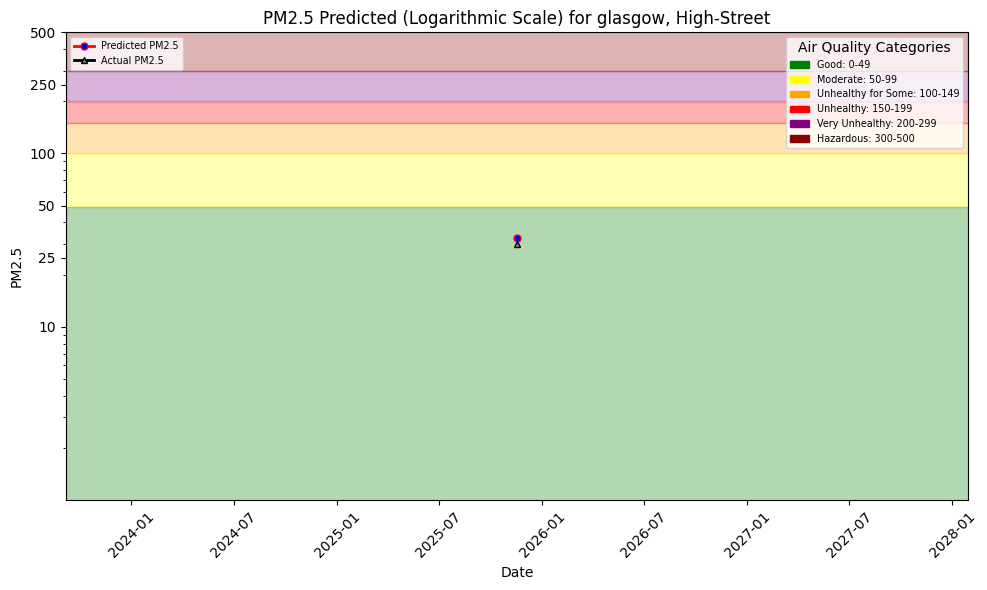

In [19]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [20]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading C:\Users\leoli\Lab1ScalableMLDL/docs/air-quality/assets/img/pm25_forecast.png: 0.000%|          | 0/…

Uploading C:\Users\leoli\Lab1ScalableMLDL/docs/air-quality/assets/img/pm25_hindcast_1day.png: 0.000%|         …

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286319/settings/fb/path/Resources/airquality


---

In [21]:
retrieved_model = mr.get_model(
    name="air_quality_xgboost_model_glasgow",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-18 12:59:18,797 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/603354 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/116607 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/113889 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/110662 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/117068 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/114679 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/116908 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/114921 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/116448 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/116517 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26641 elapsed<00:00 remaining<?

In [22]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.577276E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [26]:
import numpy as np

air_quality_fg = fs.get_feature_group(name='air_quality_glasgow', version=1)

selected_features = air_quality_fg.select(['pm25', 'date', 'street', 'pm25_lag1', 'pm25_lag2', 'pm25_lag3']).join(
    weather_fg.select_features(), on=['city']
)

df_multi = selected_features.read().sort_values(['street', 'date']).reset_index(drop=True).dropna()

weather_cols = [col for col in df_multi.columns if any(pattern in col for pattern in 
                ['temperature', 'precipitation', 'wind_speed', 'wind_direction'])]

2025-11-18 13:02:14,036 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.66s) 


In [37]:
# Get weather forecast
weather_forecast = weather_fg.filter(weather_fg.date >= today).read().sort_values('date').head(5)

recent_data = df_multi.sort_values('date').groupby('street').tail(3)
all_predictions = []

for street_name in df_multi['street'].unique():
    street_recent = recent_data[recent_data['street'] == street_name].sort_values('date')
    
    if len(street_recent) < 3:
        continue
    
    lagged_pm25 = list(street_recent['pm25'].tail(3).values)
    
    for i in range(len(weather_forecast)):
        weather_features = weather_forecast.iloc[i][weather_cols].values
        features = np.concatenate([weather_features, [lagged_pm25[-1], lagged_pm25[-2], lagged_pm25[-3]]])
        
        pred = retrieved_xgboost_model.predict([features])[0]
        
        # Get the weather data for this forecast day
        weather_row = weather_forecast.iloc[i]
        
        all_predictions.append({
            'date': weather_row['date'],
            'temperature_2m_mean': weather_row['temperature_2m_mean'],
            'precipitation_sum': weather_row['precipitation_sum'],
            'wind_speed_10m_max': weather_row['wind_speed_10m_max'],
            'wind_direction_10m_dominant': weather_row['wind_direction_10m_dominant'],
            'city': city,
            'predicted_pm25': pred,
            'street': street_name,
            'country': country
        })
        
        lagged_pm25.append(pred)
        lagged_pm25.pop(0)

batch_data_multi = pd.DataFrame(all_predictions)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.83s) 


### Create Forecast Graphs for Multiple Sensors

In [38]:
# Add required columns for monitoring
batch_data_multi['days_before_forecast_day'] = batch_data_multi.groupby('street').cumcount() + 1
batch_data_multi = batch_data_multi.sort_values(by=['street', 'date'])
batch_data_multi

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-19 00:00:00+00:00,3.20,0.0,9.686609,318.012878,glasgow,43.203560,anderston,unitedkingdom,1
1,2025-11-20 00:00:00+00:00,3.95,0.0,10.495713,329.036316,glasgow,50.858856,anderston,unitedkingdom,2
2,2025-11-21 00:00:00+00:00,5.35,0.0,19.242327,197.418060,glasgow,47.397446,anderston,unitedkingdom,3
3,2025-11-22 00:00:00+00:00,6.00,0.4,26.319420,130.006195,glasgow,50.924786,anderston,unitedkingdom,4
4,2025-11-23 00:00:00+00:00,6.85,0.1,9.178235,228.179916,glasgow,54.760216,anderston,unitedkingdom,5
5,2025-11-19 00:00:00+00:00,3.20,0.0,9.686609,318.012878,glasgow,43.223198,broomhill,unitedkingdom,1
6,2025-11-20 00:00:00+00:00,3.95,0.0,10.495713,329.036316,glasgow,52.748291,broomhill,unitedkingdom,2
7,2025-11-21 00:00:00+00:00,5.35,0.0,19.242327,197.418060,glasgow,49.617081,broomhill,unitedkingdom,3
8,2025-11-22 00:00:00+00:00,6.00,0.4,26.319420,130.006195,glasgow,50.924786,broomhill,unitedkingdom,4
9,2025-11-23 00:00:00+00:00,6.85,0.1,9.178235,228.179916,glasgow,54.760216,broomhill,unitedkingdom,5


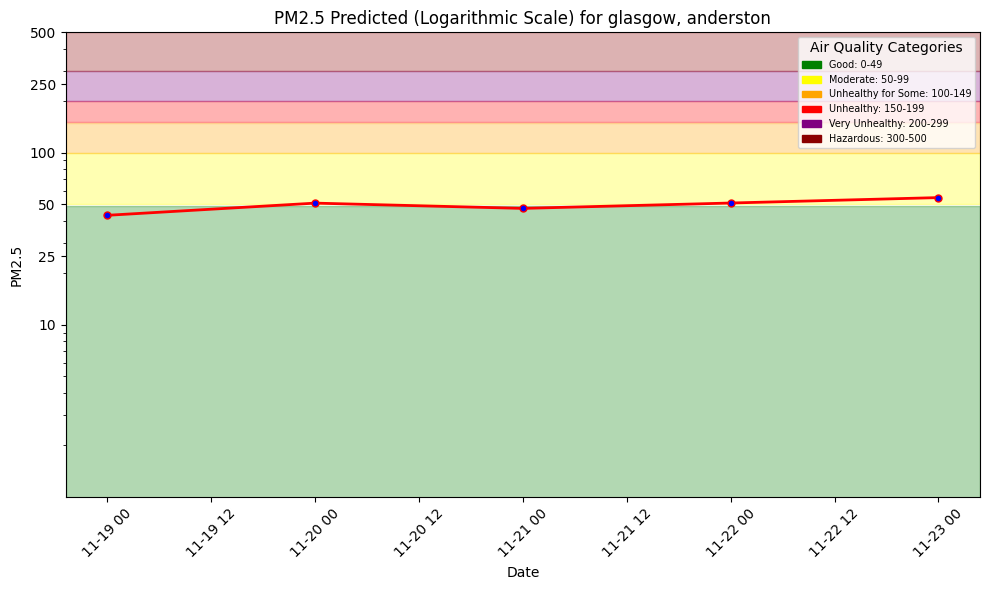

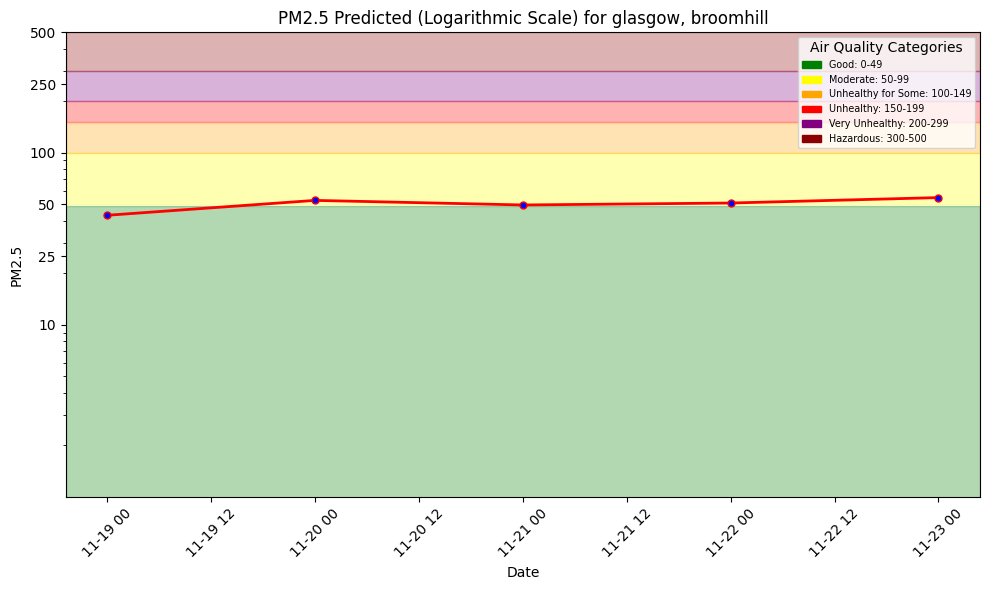

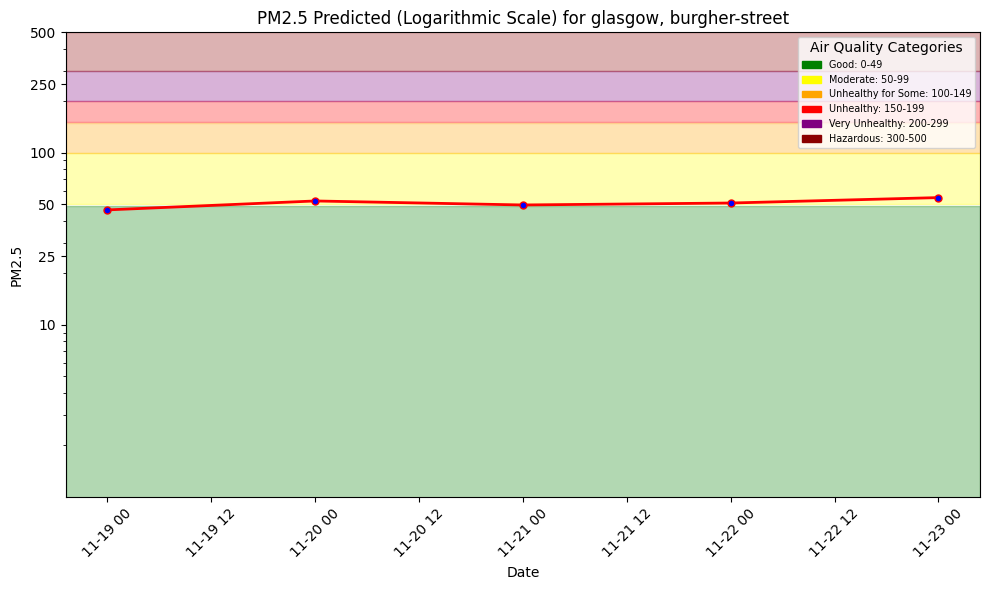

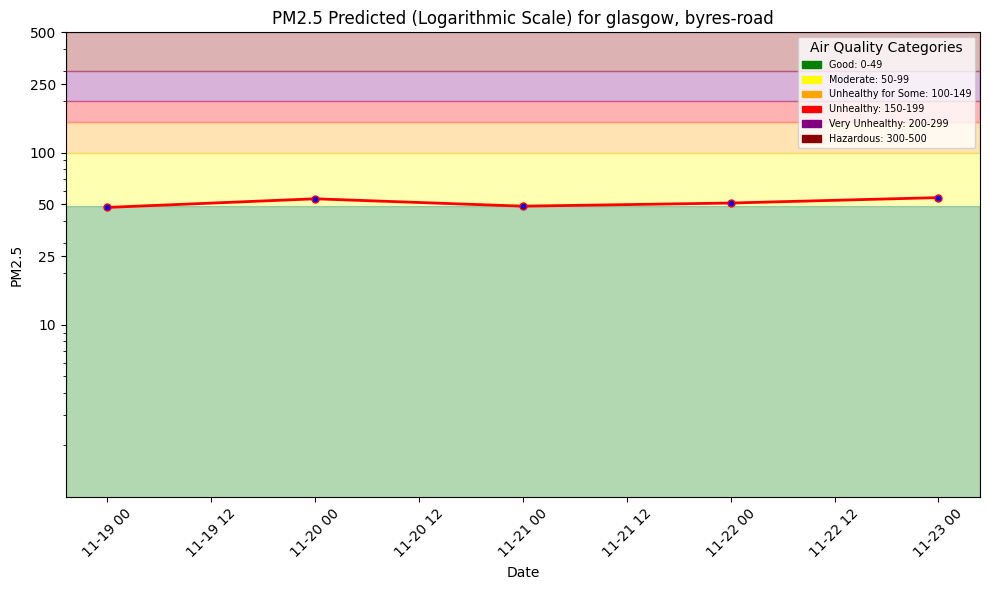

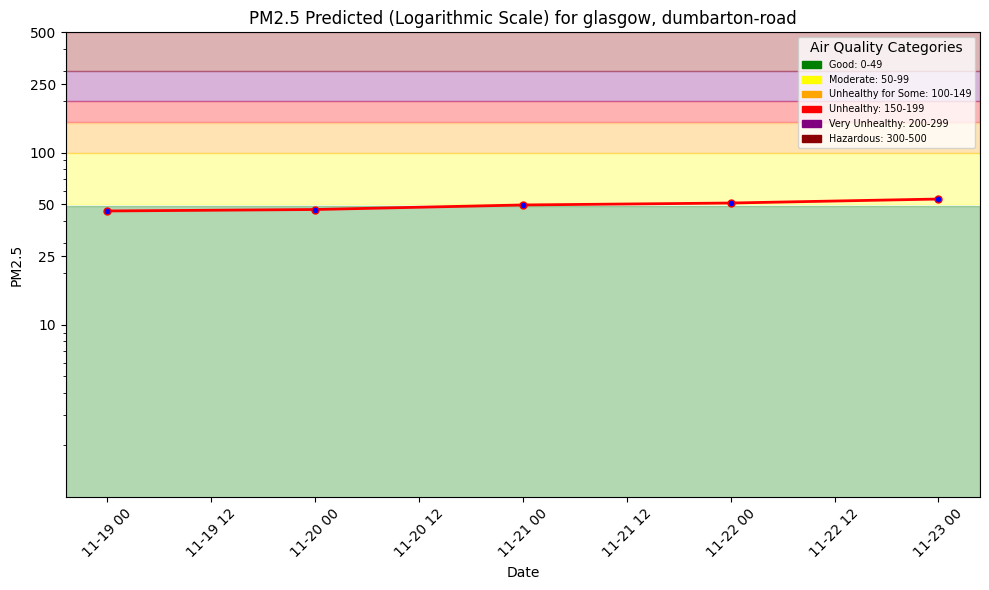

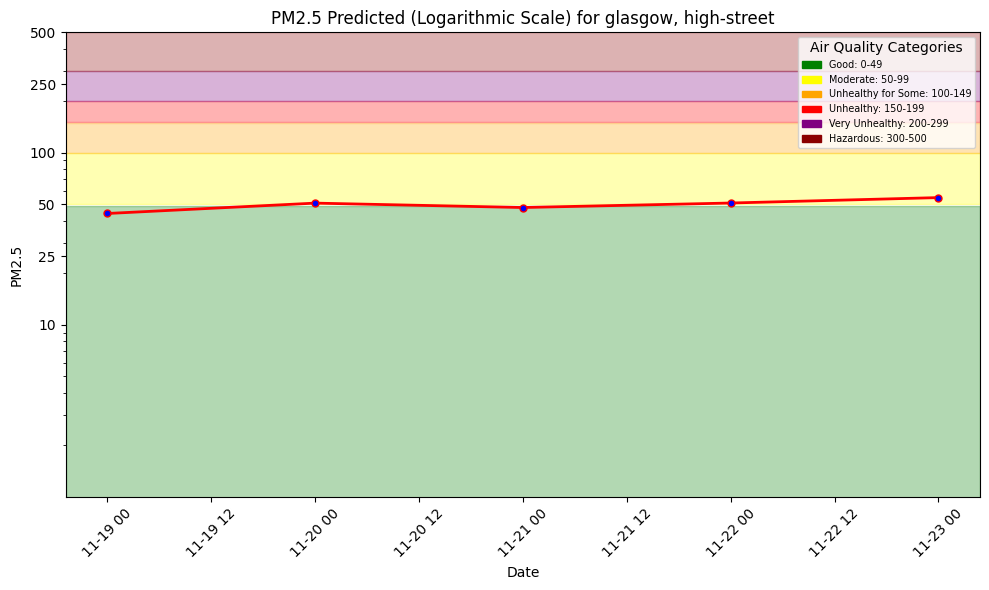

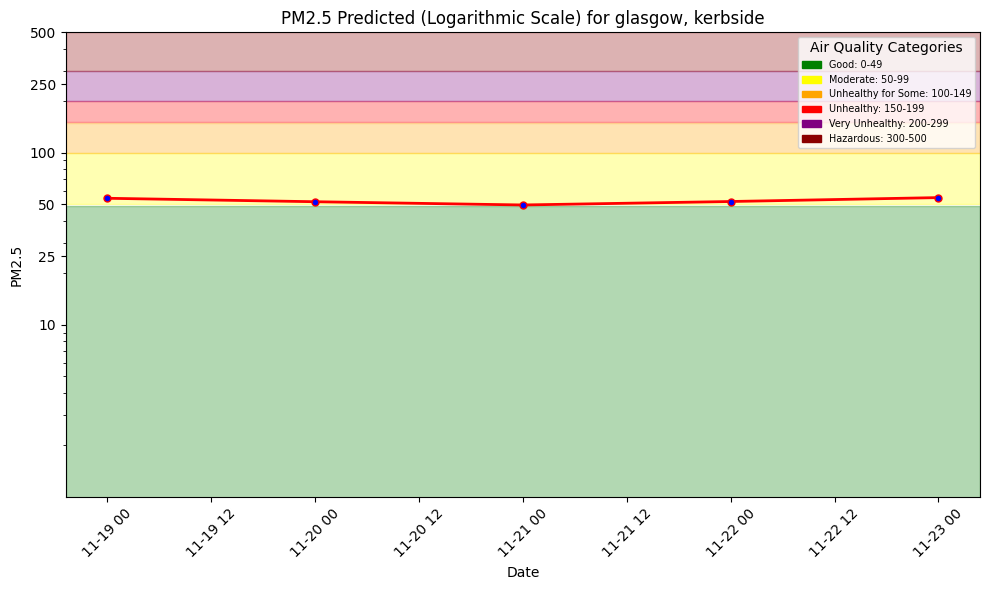

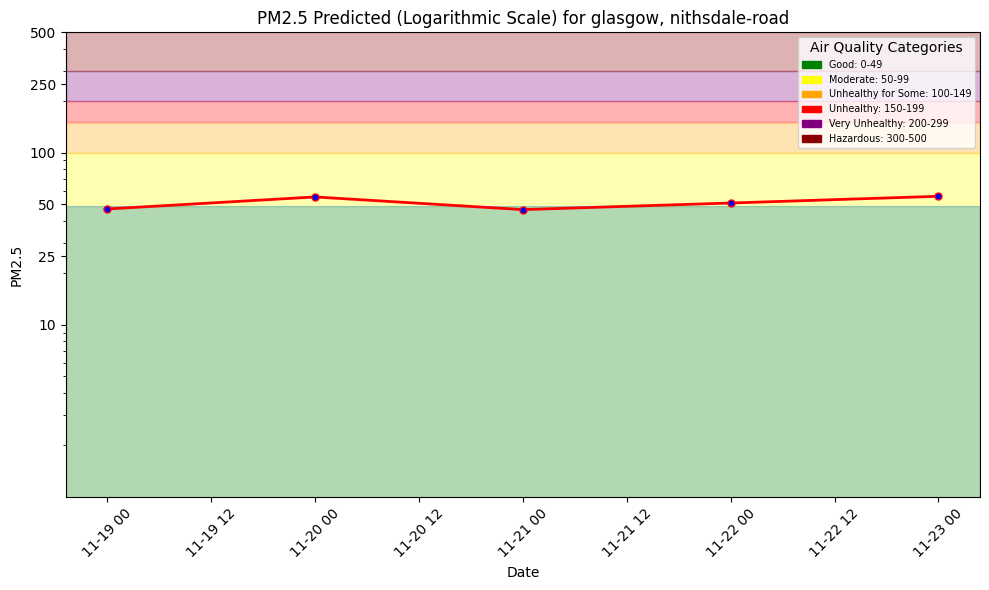

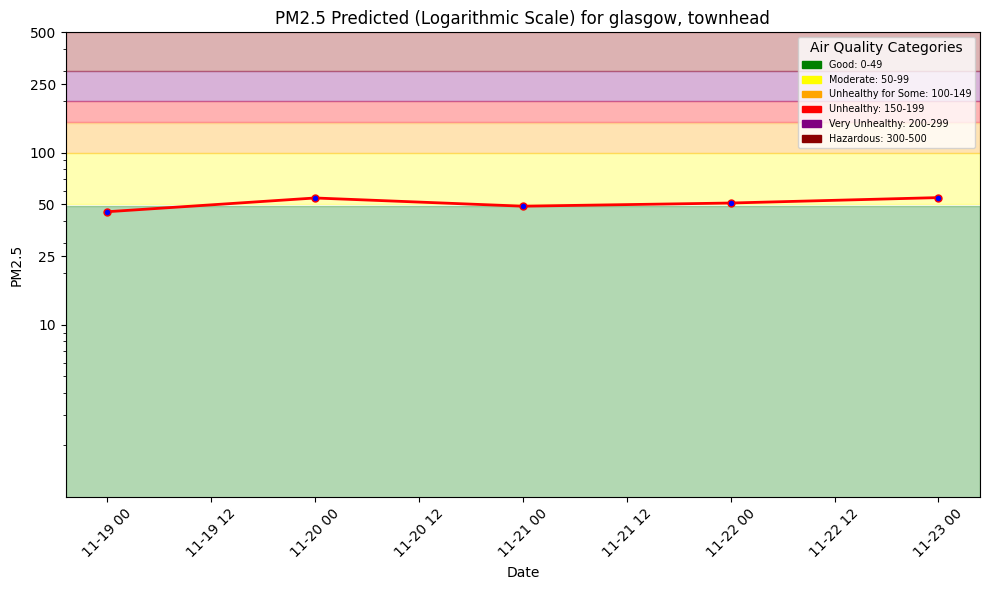

In [39]:
# Create forecast plot for each sensor
for street_name in df_multi['street'].unique():
    street_preds = batch_data_multi[batch_data_multi['street'] == street_name].copy()
    
    pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_{city}_{street_name}.png"
    
    plt = util.plot_air_quality_forecast(city, street_name, street_preds, pred_file_path)
    plt.show()

In [40]:
# Get or create feature group for monitoring
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

# Insert all predictions (for all sensors)
monitor_fg.insert(batch_data_multi, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 45/45 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286319/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-18 13:24:45,809 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 13:24:49,018 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 13:26:30,936 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 13:26:31,087 INFO: Waiting for log aggregation to finish.
2025-11-18 13:26:53,016 INFO: Execution finished successfully.


(Job('aq_predictions_1_offline_fg_materialization', 'SPARK'), None)

### Create comparison between predicted and actual value



In [45]:
# Get actual air quality data

air_quality_df = air_quality_fg.select(['date', 'pm25', 'street']).read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.50s) 


,date,pm25,street
0,2019-08-17 00:00:00+00:00,20.0,broomhill
1,2020-06-22 00:00:00+00:00,16.0,anderston
2,2021-04-08 00:00:00+00:00,24.0,broomhill
3,2022-07-08 00:00:00+00:00,4.0,anderston
4,2018-05-25 00:00:00+00:00,60.0,byres-road
...,...,...,...
24604,2024-11-02 00:00:00+00:00,15.0,dumbarton-road
24605,2023-10-19 00:00:00+00:00,21.0,kerbside
24606,2023-09-04 00:00:00+00:00,24.0,broomhill
24607,2023-01-29 00:00:00+00:00,17.0,broomhill


In [51]:
# Create hindcast for each sensor (comparing predictions to actuals)
hindcast_dfs = {}

for street_name in df_multi['street'].unique():
    # Get predictions for this street (1-day forecasts only)
    street_preds = monitoring_df[monitoring_df['street'] == street_name][['date', 'predicted_pm25']].copy()
    
    # Get actuals for this street
    street_actuals = air_quality_df[air_quality_df['street'] == street_name][['date', 'pm25']].copy()
    
    # Merge predictions with actuals
    hindcast_df = pd.merge(street_preds, street_actuals, on="date")
    hindcast_df = hindcast_df.sort_values(by=['date'])
    
    # If no hindcast data available, backfill from existing data (take last 1 row)
    if len(hindcast_df) == 0:
        # Get last historical data point for this street
        street_historical = df_multi[df_multi['street'] == street_name].tail(1).copy()
        
        # Make prediction on that one point
        features = street_historical[weather_cols + ['pm25_lag1', 'pm25_lag2', 'pm25_lag3']].values
        pred = retrieved_xgboost_model.predict(features)[0]
        
        hindcast_df = pd.DataFrame({
            'date': street_historical['date'].values,
            'predicted_pm25': [pred],
            'pm25': street_historical['pm25'].values
        })
    
    hindcast_dfs[street_name] = hindcast_df

# Show one example
print(f"Hindcast example for {list(hindcast_dfs.keys())[0]}:")
hindcast_dfs[list(hindcast_dfs.keys())[0]]

Hindcast example for anderston:


,date,predicted_pm25,pm25
0,2025-11-18,54.860737,30.0


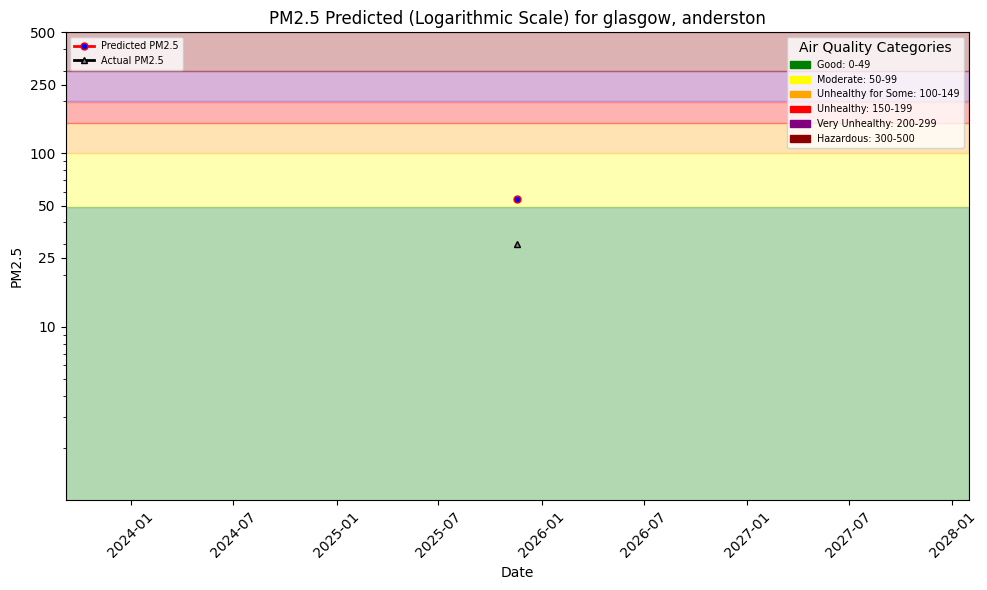

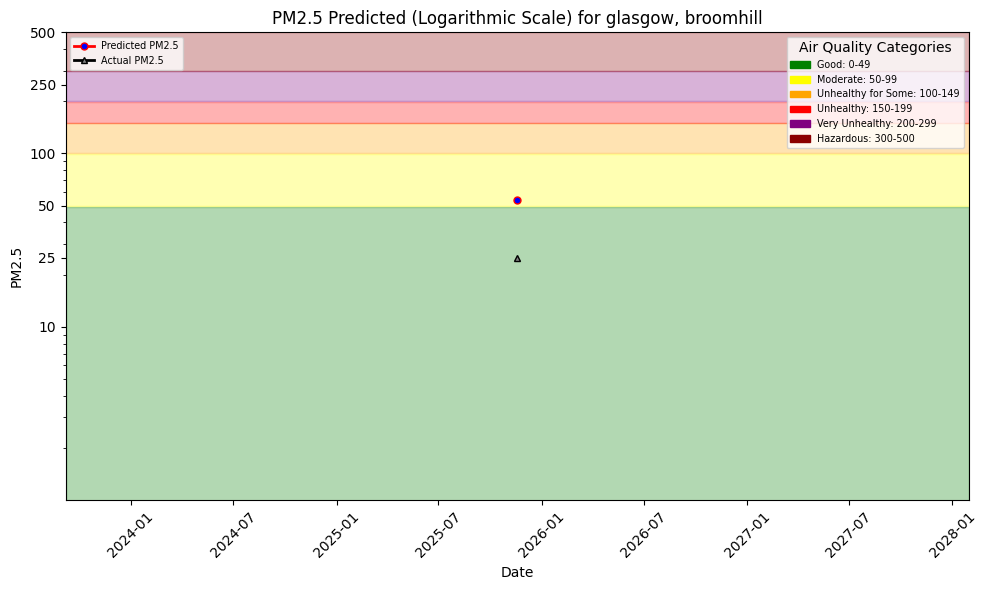

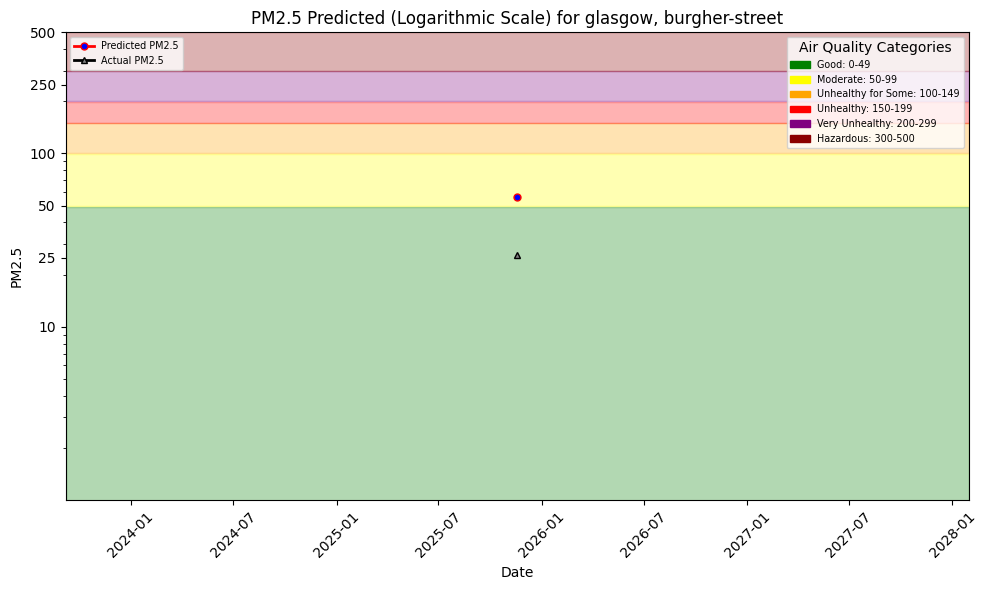

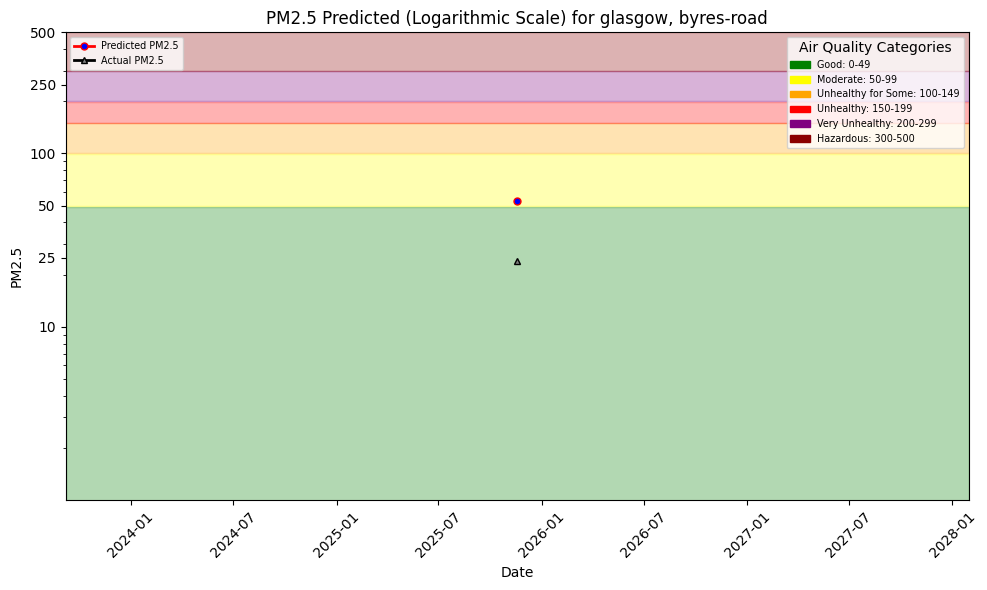

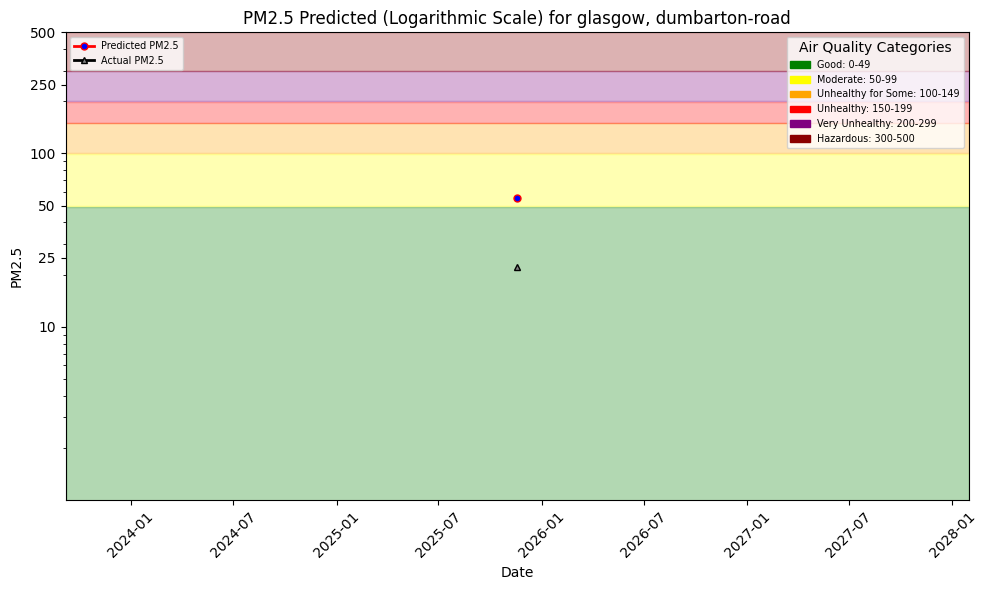

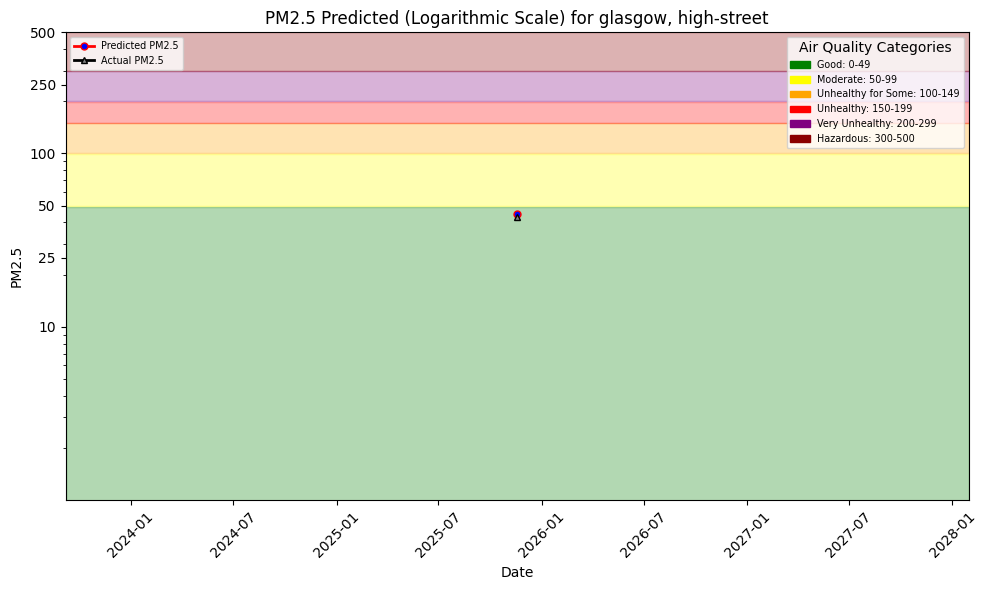

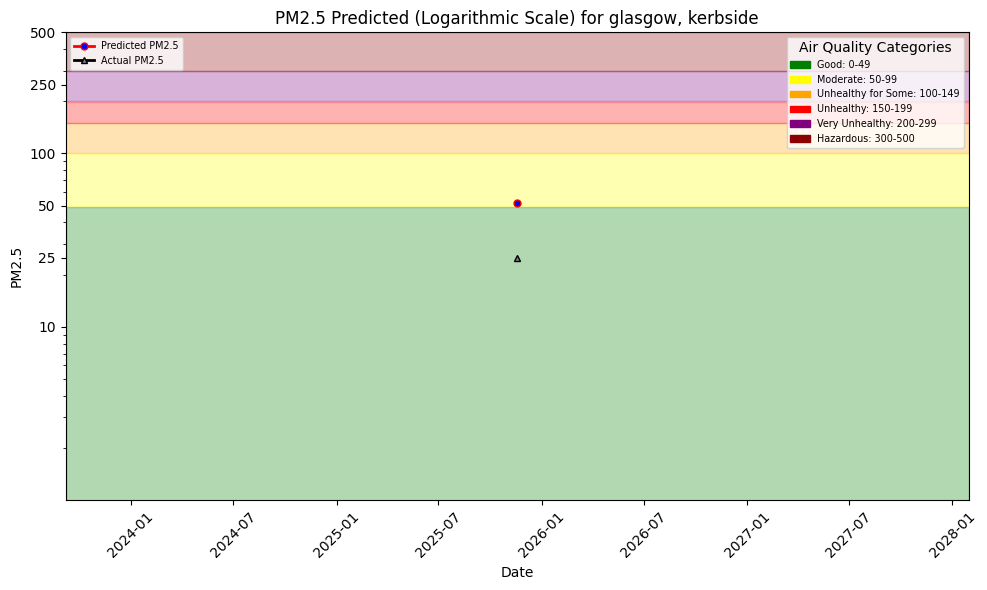

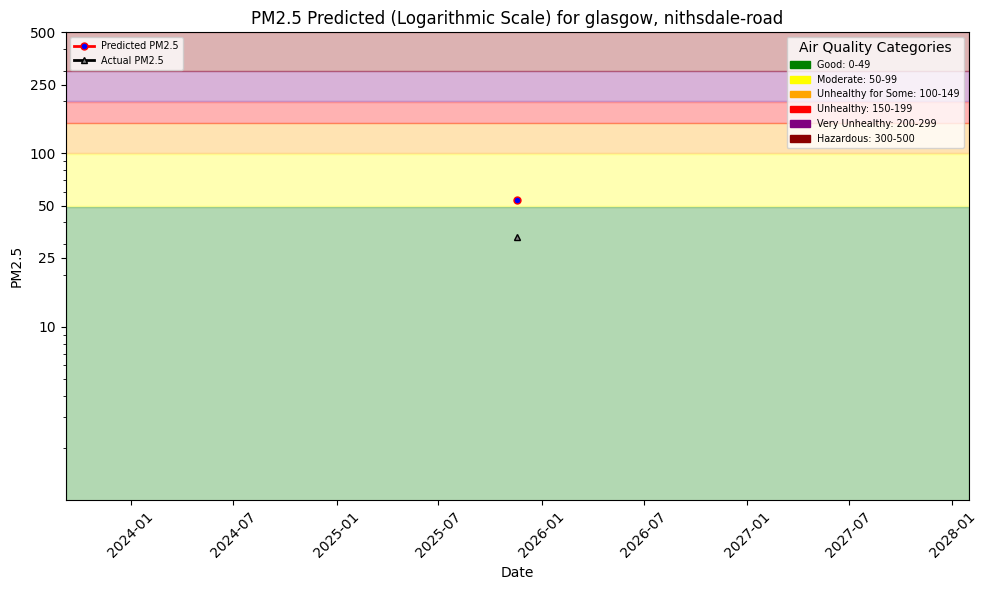

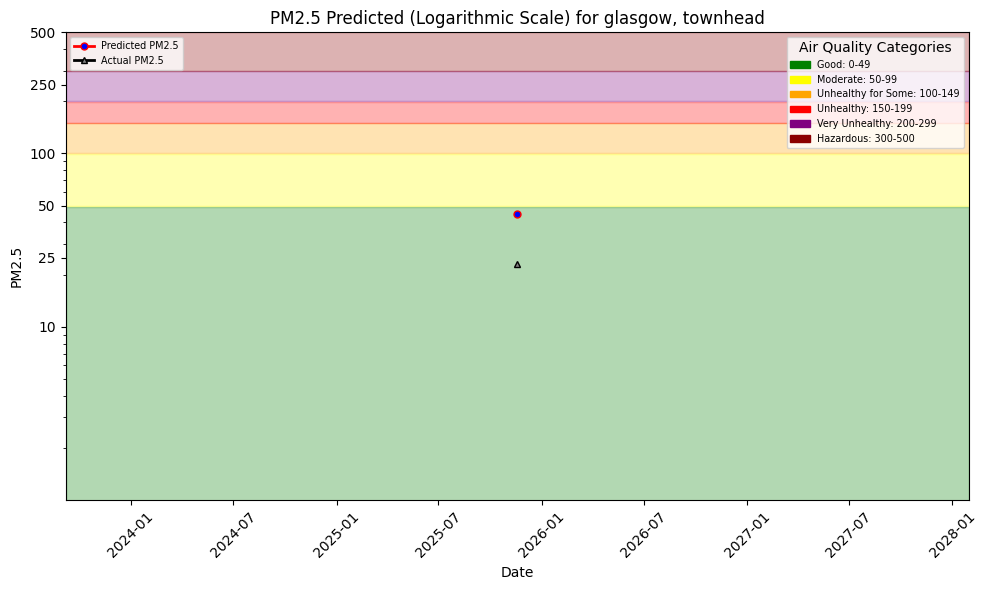

In [52]:
# Create hindcast plot for each sensor
for street_name, hindcast_df in hindcast_dfs.items():
    hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_{city}_{street_name}.png"
    
    plt = util.plot_air_quality_forecast(city, street_name, hindcast_df, hindcast_file_path, hindcast=True)
    plt.show()